In [61]:
from epimodel import EpidemiologicalParameters, DefaultModel, preprocess_data
from epimodel.pymc3_models.base_model import produce_CIs, add_cms_to_plot

import numpy as np
import pymc3 as pm
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
%matplotlib inline

In [62]:
data = preprocess_data('../double-entry-data/double_entry_final.csv', last_day='2020-05-30', smoothing=1)

Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values


In [63]:
def month_to_str(x):
    if x == 1:
        return "JAN"
    if x == 2:
        return "FEB"
    if x == 3:
        return "MAR"
    if x == 4:
        return "APR"
    if x == 5:
        return "MAY"

cols = sns.cubehelix_palette(3, start=0.2, light=0.6, dark=0.1, rot=0.2)
cm_plot_style = [
            ("\uf963", "black"), # mask
            ("\uf0c0", cols[0]), # ppl
            ("\uf0c0", cols[1]), # ppl
            ("\uf0c0", cols[2]), # ppl
            ("\uf07a", cols[0]), # shop 1
            ("\uf07a", cols[2]), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]


class ResultsObject():
    def __init__(self, indx, trace):
        self.CMReduction = trace.CMReduction
        self.RegionR = trace.RegionR[:, indx]
        self.InfectedCases = trace.InfectedCases[:, indx, :]
        self.InfectedDeaths = trace.InfectedDeaths[:, indx, :]
        self.ExpectedCases = trace.ExpectedCases[:, indx, :]
        self.ExpectedDeaths = trace.ExpectedDeaths[:, indx, :]
        self.PsiCases = trace.PsiCases
        self.PsiDeaths = trace.PsiDeaths

In [64]:
start_d_i = 30 

data.unmask_all()
data.mask_reopenings()
for r_i, r in enumerate(data.Rs):
    p_i = r_i % 12
    
    f_i = int(r_i/12)
    
    if r_i == 0:
        plt.figure(figsize=(10, 14), dpi=300)
    elif r_i % 12 == 0:
#         plt.tight_layout()
#         ax.legend(shadow=True, fancybox=True, loc = "upper center", bbox_to_anchor = (-0.85, -0.25), fontsize=8, ncol=4)
#         plt.savefig(f"figs/holdouts/FigureHoldouts{f_i}.pdf", bbox_inches='tight')
        plt.figure(figsize=(10, 14), dpi=300)
#     elif r_i + 1 == len(data.Rs):
#         plt.tight_layout()
#         ax.legend(shadow=True, fancybox=True, loc = "upper center", bbox_to_anchor = (1.9, -0.25), fontsize=8, ncol=4)
#         plt.savefig(f"figs/holdouts/FigureHoldouts{f_i+1}.pdf", bbox_inches='tight')
        
    plt.subplot(4, 3, p_i + 1)
    ax = plt.gca()
    
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]-3
    else:
        end_d_i = len(data.Ds)
    
    data.mask_region(r)
    
    try:   
        res = pickle.load(open(f"../../server/sensitivity_default_final/region_holdout/{r}.pkl", "rb"))
    except:
        print(f'Could not load ../../server/sensitivity_default_final/region_holdout/{r}.pkl')
        continue
    
#     means_d, lu_id, up_id, _, _ = produce_CIs(
#                 res.InfectedDeaths
#             )
    
#     means_c, lu_ic, up_ic, _, _ = produce_CIs(
#                 res.InfectedCases
#             )

    ec = res.ExpectedDeaths
    nS, nDs = ec.shape
    
    try:
        dist = pm.NegativeBinomial.dist(mu=ec, alpha=np.repeat(res.PsiDeaths.reshape((nS, 1)), nDs, axis=-1))
        ec_output = dist.random()
    except ValueError:
        ec_output = 0 * ec

    means_expected_deaths, lu_ed, up_ed, _, _ = produce_CIs(
        ec_output
    )
    
    eco = res.ExpectedCases
    nS, nDs = eco.shape
    
    try:
        dist = pm.NegativeBinomial.dist(mu=eco, alpha=np.repeat(res.PsiCases.reshape((nS, 1)), nDs, axis=-1))
        eco_output = dist.random()
    except ValueError:
        eco_output = 10**-10 * ec

    means_expected_cases, lu_ec, up_ec, _, _= produce_CIs(
        eco_output
    )
    

    days = data.Ds
    days_x = np.arange(len(days))
    deaths = data.NewDeaths[r_i, :]
    cases = data.NewCases[r_i, :]

    ax = plt.gca()
#     plt.plot(
#         days_x,
#         means_d,
#         label="Daily Infections - Later Fatal",
#         zorder=1,
#         color="tab:orange",
#         alpha=0.25
#     )

#     plt.fill_between(
#         days_x, lu_id, up_id, alpha=0.15, color="tab:orange", linewidth=0
#     )

    plt.plot(
        days_x,
        means_expected_deaths,
        label="Predicted Daily Deaths",
        zorder=2,
        color="tab:red"
    )

    plt.fill_between(
        days_x, lu_ed, up_ed, alpha=0.25, color="tab:red", linewidth=0
    )

    plt.scatter(
        days_x,
        deaths,
        label="Recorded Daily Deaths",
        marker="o",
        s=10,
        color="tab:red",
        alpha=0.9,
        zorder=3,
    )

    plt.scatter(
        days_x,
        deaths.data,
        label="Heldout Daily Deaths (Cases)",
        marker="o",
        s=12,
        edgecolor="tab:red",
        facecolor="white",
        linewidth=1,
        alpha=0.9,
        zorder=2,
    )
    
#     plt.plot(
#         days_x,
#         means_c,
#         label="Daily Infections - Later Reported",
#         zorder=1,
#         color="tab:purple",
#         alpha=0.25
#     )

#     plt.fill_between(
#         days_x, lu_ic, up_ic, alpha=0.15, color="tab:purple", linewidth=0
#     )

    plt.plot(
        days_x,
        means_expected_cases,
        label="Predicted Daily Confirmed Cases",
        zorder=2,
        color="tab:blue"
    )

    plt.fill_between(
        days_x, lu_ec, up_ec, alpha=0.25, color="tab:blue", linewidth=0
    )

    plt.scatter(
        days_x,
        cases,
        label="Recorded Daily Confirmed Cases",
        marker="o",
        s=10,
        color="tab:blue",
        alpha=0.9,
        zorder=3,
    )

    plt.scatter(
        days_x,
        cases.data,
        label="Heldout Daily Confirmed Cases (Cases)",
        marker="o",
        s=12,
        edgecolor="tab:blue",
        facecolor="white",
        linewidth=1,
        alpha=0.9,
        zorder=2,
    )

    ax.set_yscale("log")
    plt.ylim([10 ** 0, 10 ** 6])
    locs = np.arange(start_d_i, end_d_i, 14)
    xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
    plt.xticks(locs, xlabels, rotation=-30, ha="left")
    plt.xlim((start_d_i, end_d_i))
    
    add_cms_to_plot(ax, data.ActiveCMs, r_i, start_d_i, end_d_i, data.Ds, cm_plot_style)
    plt.title(data.RNames[r][0], fontsize=12)
    
    if r_i % 12 == 11:
        plt.tight_layout()
        ax.legend(shadow=True, fancybox=True, loc = "upper center", bbox_to_anchor = (-0.75, -0.25), fontsize=8, ncol=3)
        plt.savefig(f"figs/holdouts/FigureHoldouts{f_i}.pdf", bbox_inches='tight')
    elif r_i + 1 == len(data.Rs):
        plt.tight_layout()
        ax.legend(shadow=True, fancybox=True, loc = "upper center", bbox_to_anchor = (0.75, -0.25), fontsize=8, ncol=3)
        plt.savefig(f"figs/holdouts/FigureHoldouts{f_i}.pdf", bbox_inches='tight')

Masking AL from 2020-04-30 00:00:00+00:00
Masking AD from 2020-05-21 00:00:00+00:00
Masking AT from 2020-05-04 00:00:00+00:00
Masking AT from 2020-05-21 00:00:00+00:00
Masking BE from 2020-05-14 00:00:00+00:00
Masking BA from 2020-05-17 00:00:00+00:00
Masking BG from 2020-05-04 00:00:00+00:00
Masking BG from 2020-05-21 00:00:00+00:00
Masking HR from 2020-04-30 00:00:00+00:00
Masking HR from 2020-05-14 00:00:00+00:00
Masking HR from 2020-05-29 00:00:00+00:00
Masking CZ from 2020-04-27 00:00:00+00:00
Masking CZ from 2020-05-14 00:00:00+00:00
Masking CZ from 2020-05-28 00:00:00+00:00
Masking DK from 2020-04-23 00:00:00+00:00
Masking DK from 2020-05-14 00:00:00+00:00
Masking FI from 2020-05-17 00:00:00+00:00
Masking FR from 2020-05-14 00:00:00+00:00
Masking GE from 2020-05-26 00:00:00+00:00
Masking GE from 2020-05-27 00:00:00+00:00
Masking DE from 2020-04-23 00:00:00+00:00
Masking DE from 2020-05-07 00:00:00+00:00
Masking DE from 2020-05-09 00:00:00+00:00
Masking GR from 2020-05-07 00:00:0

'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


NameError: name 'f' is not defined

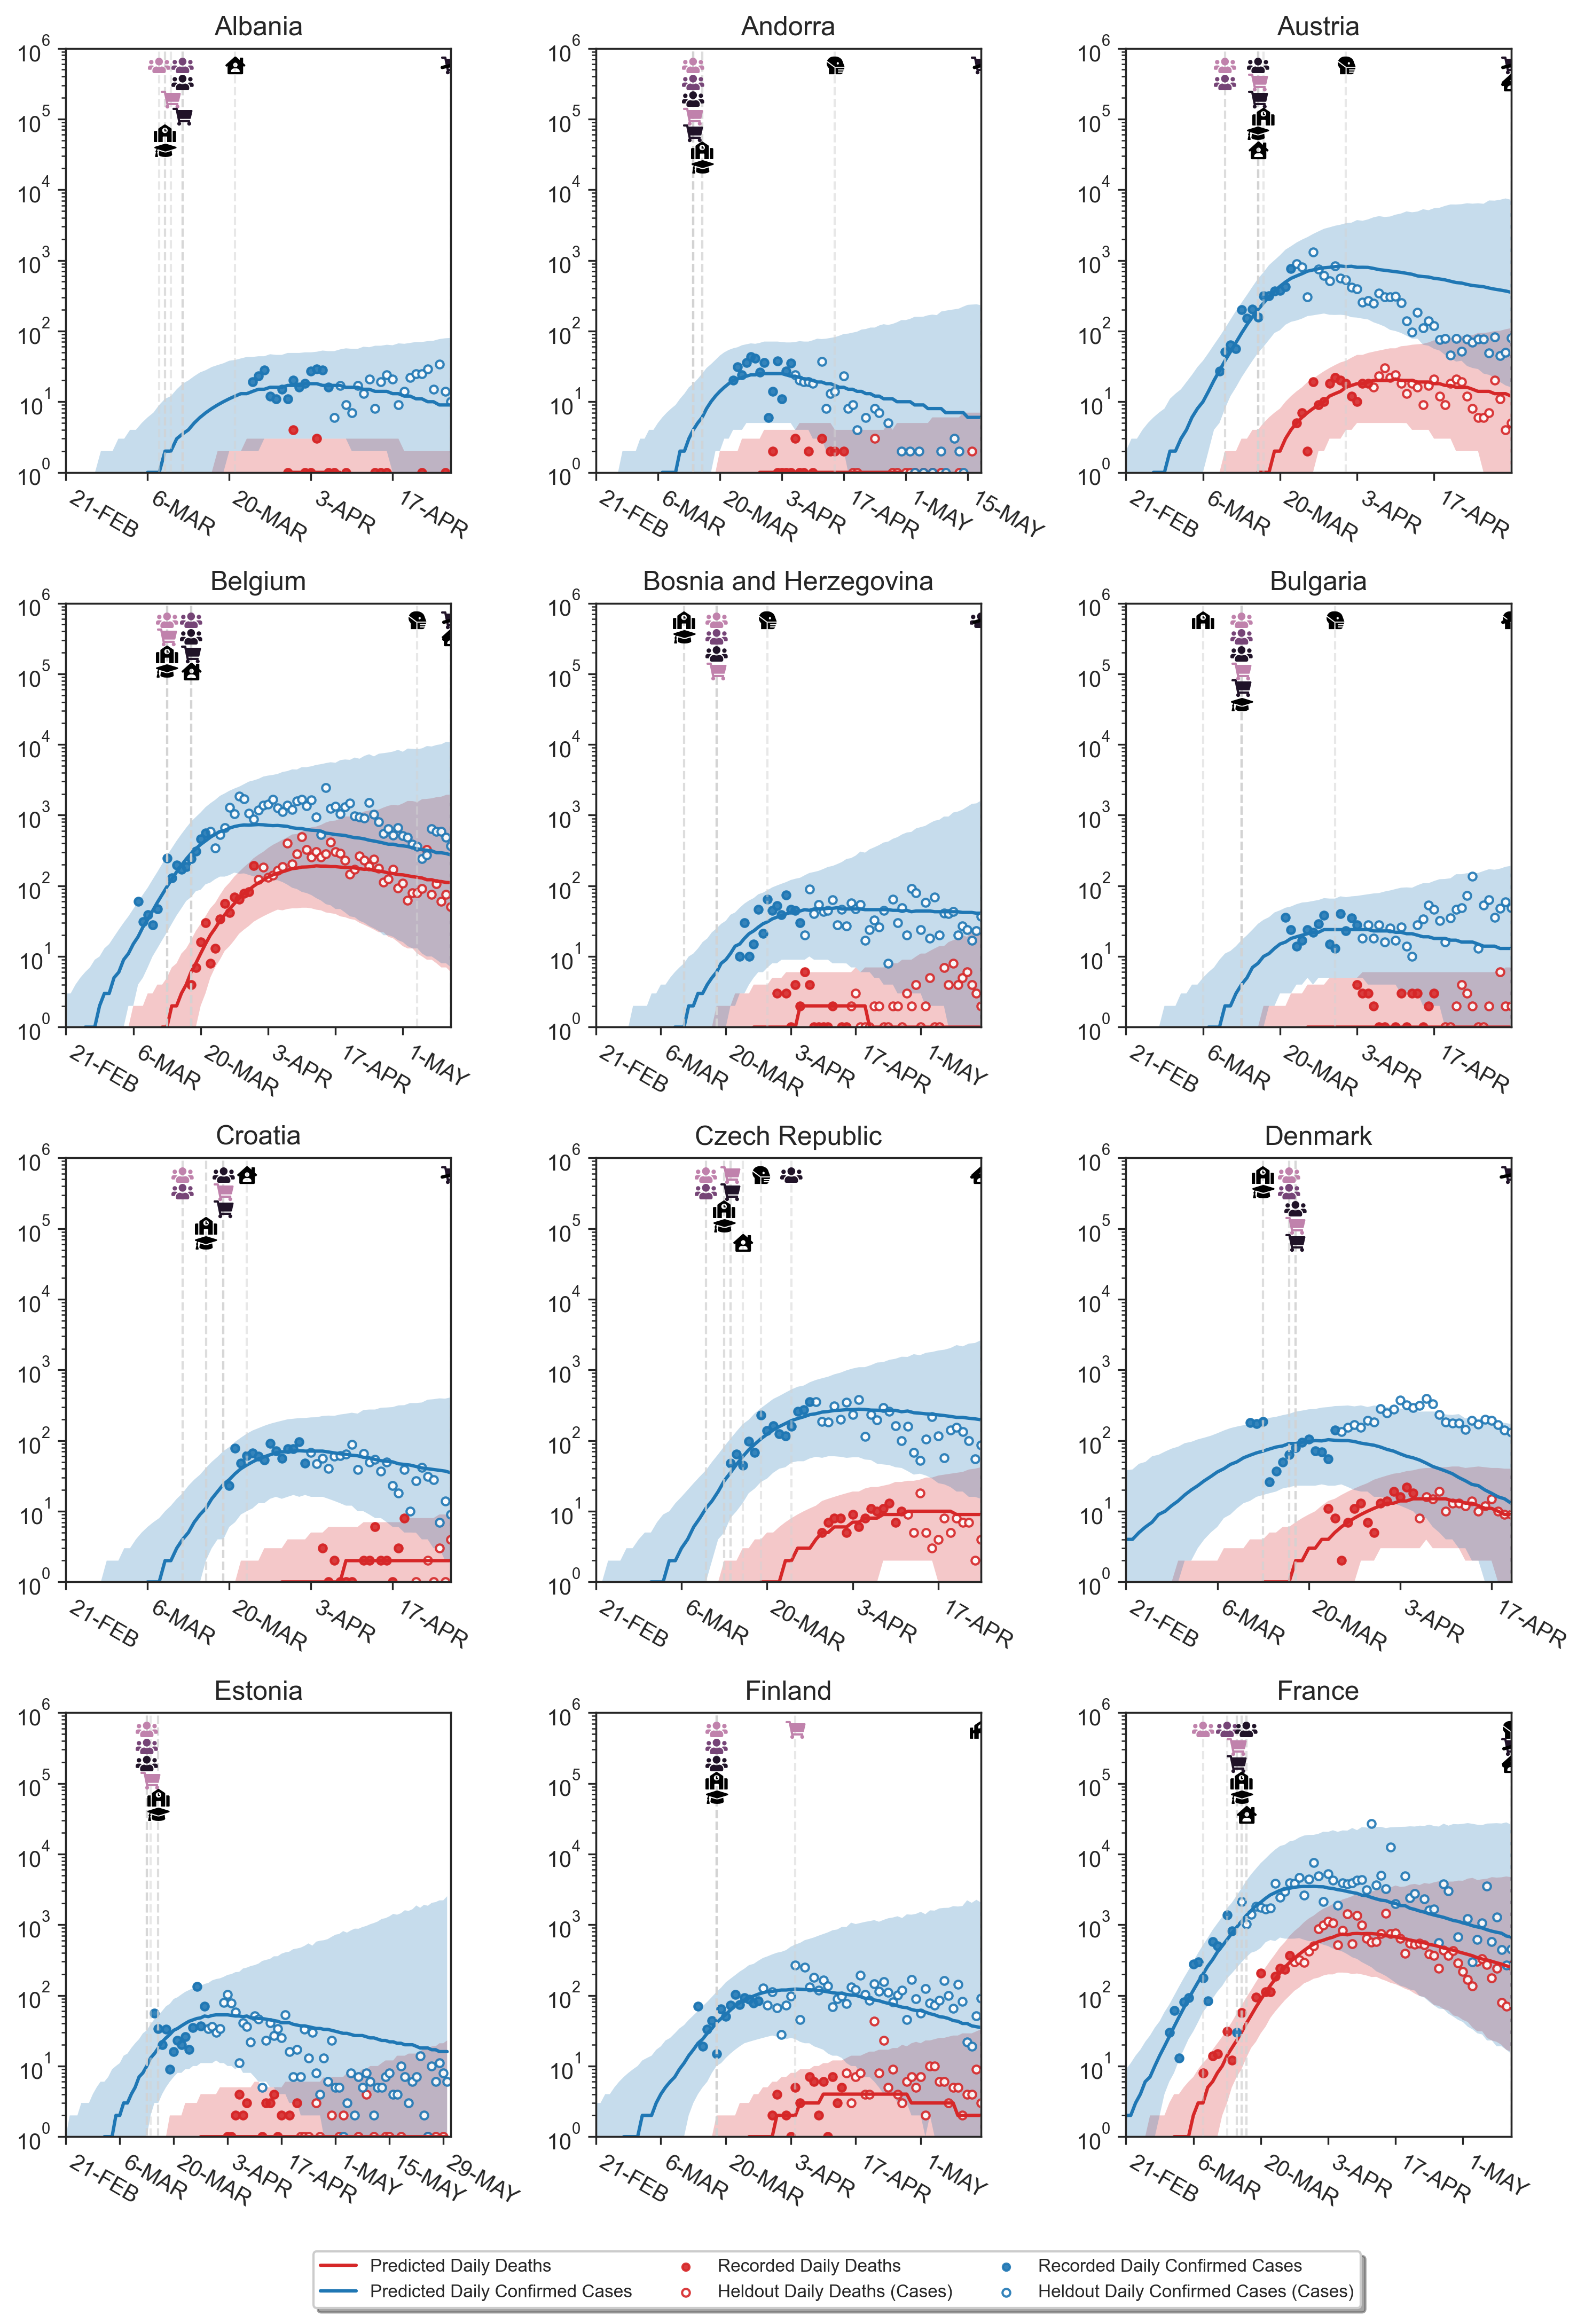

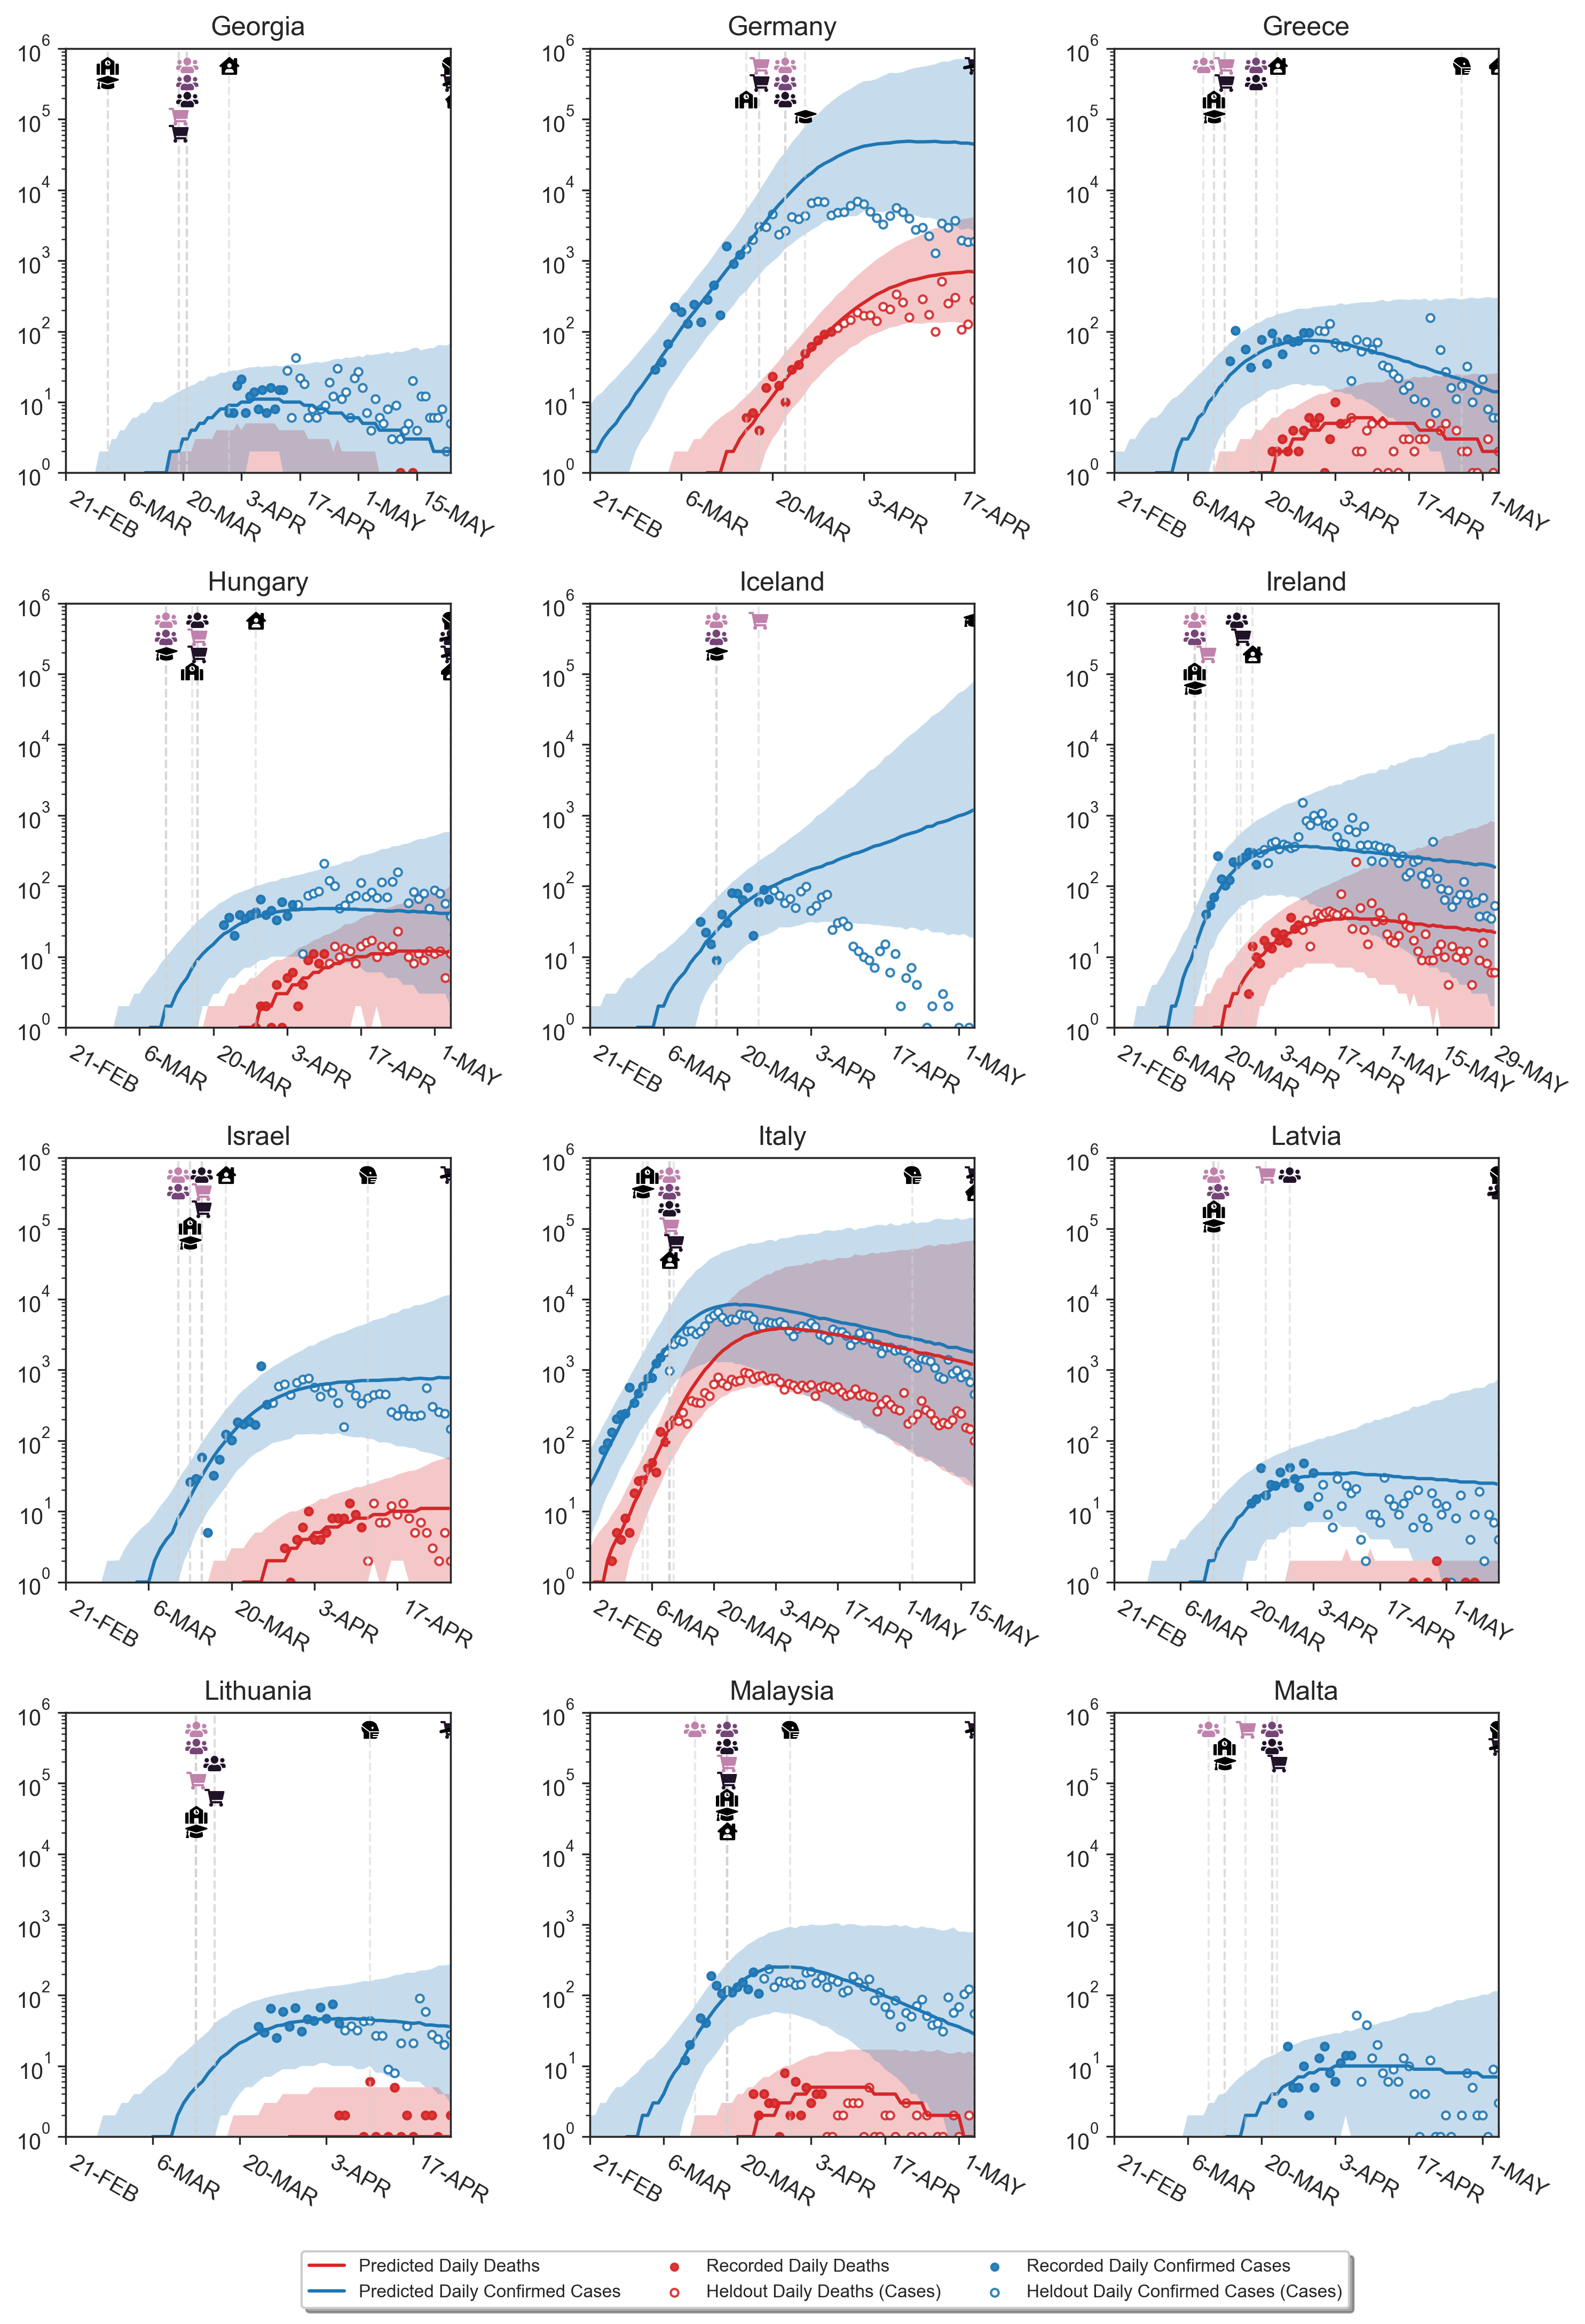

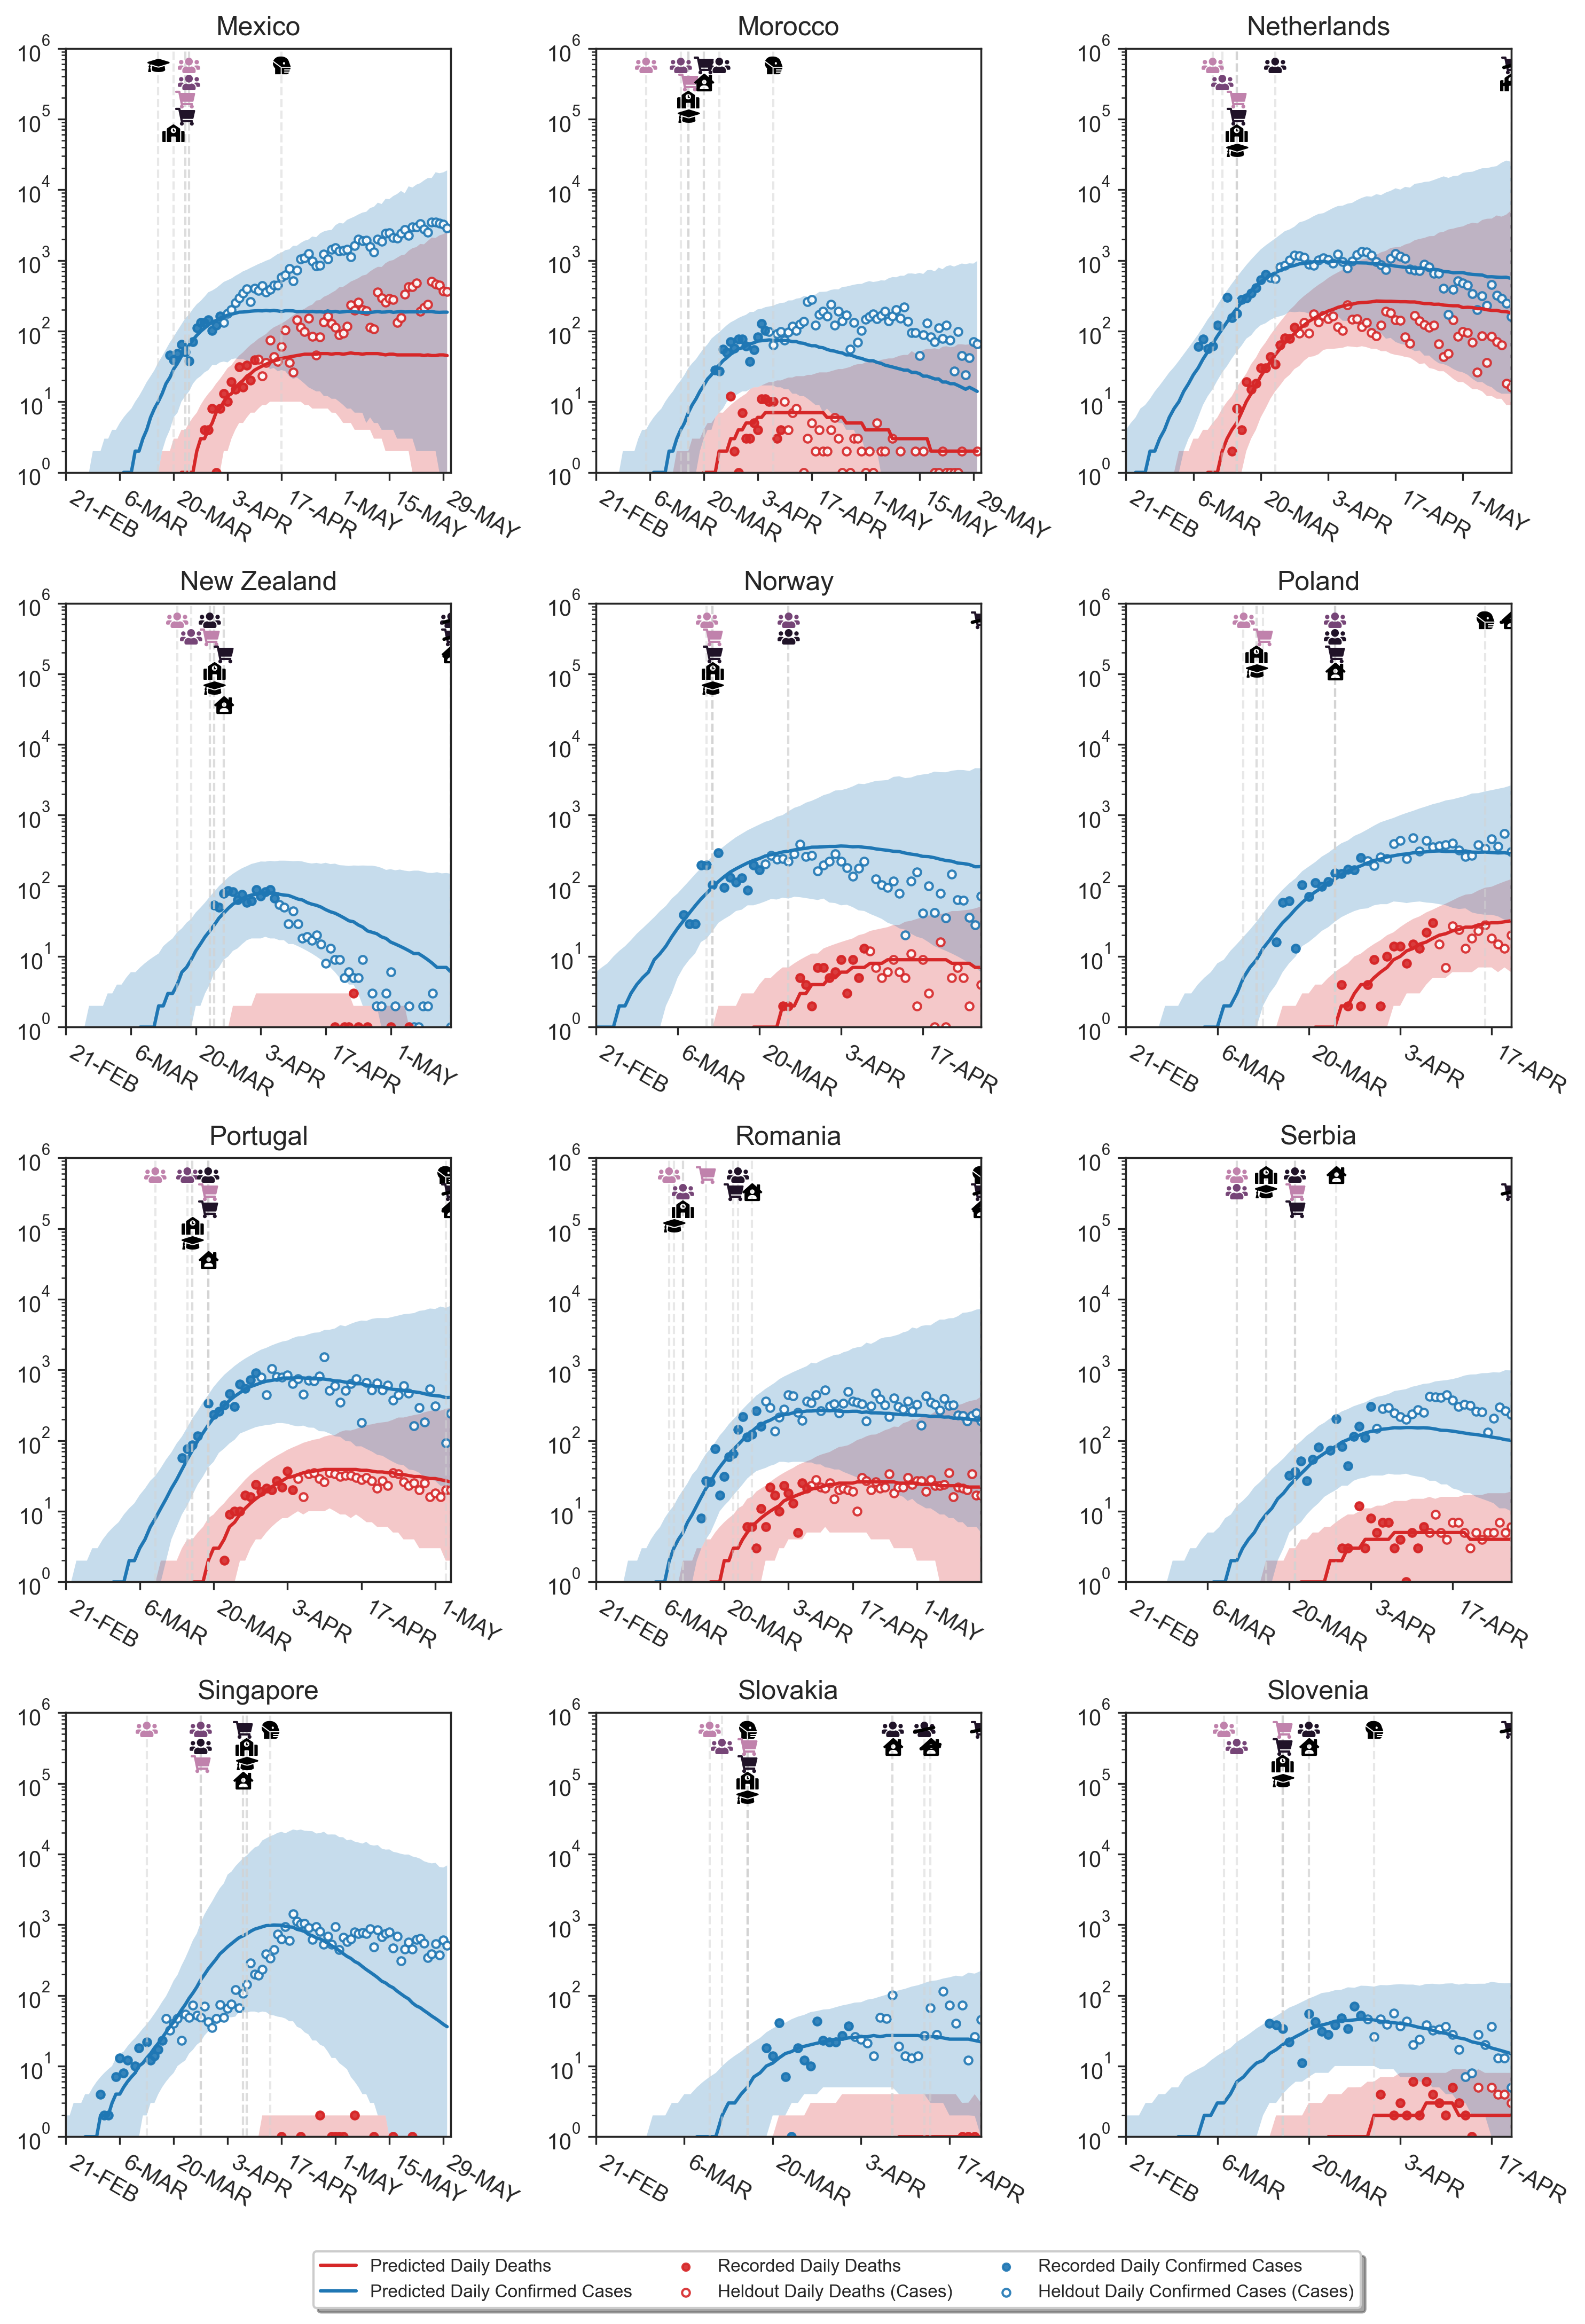

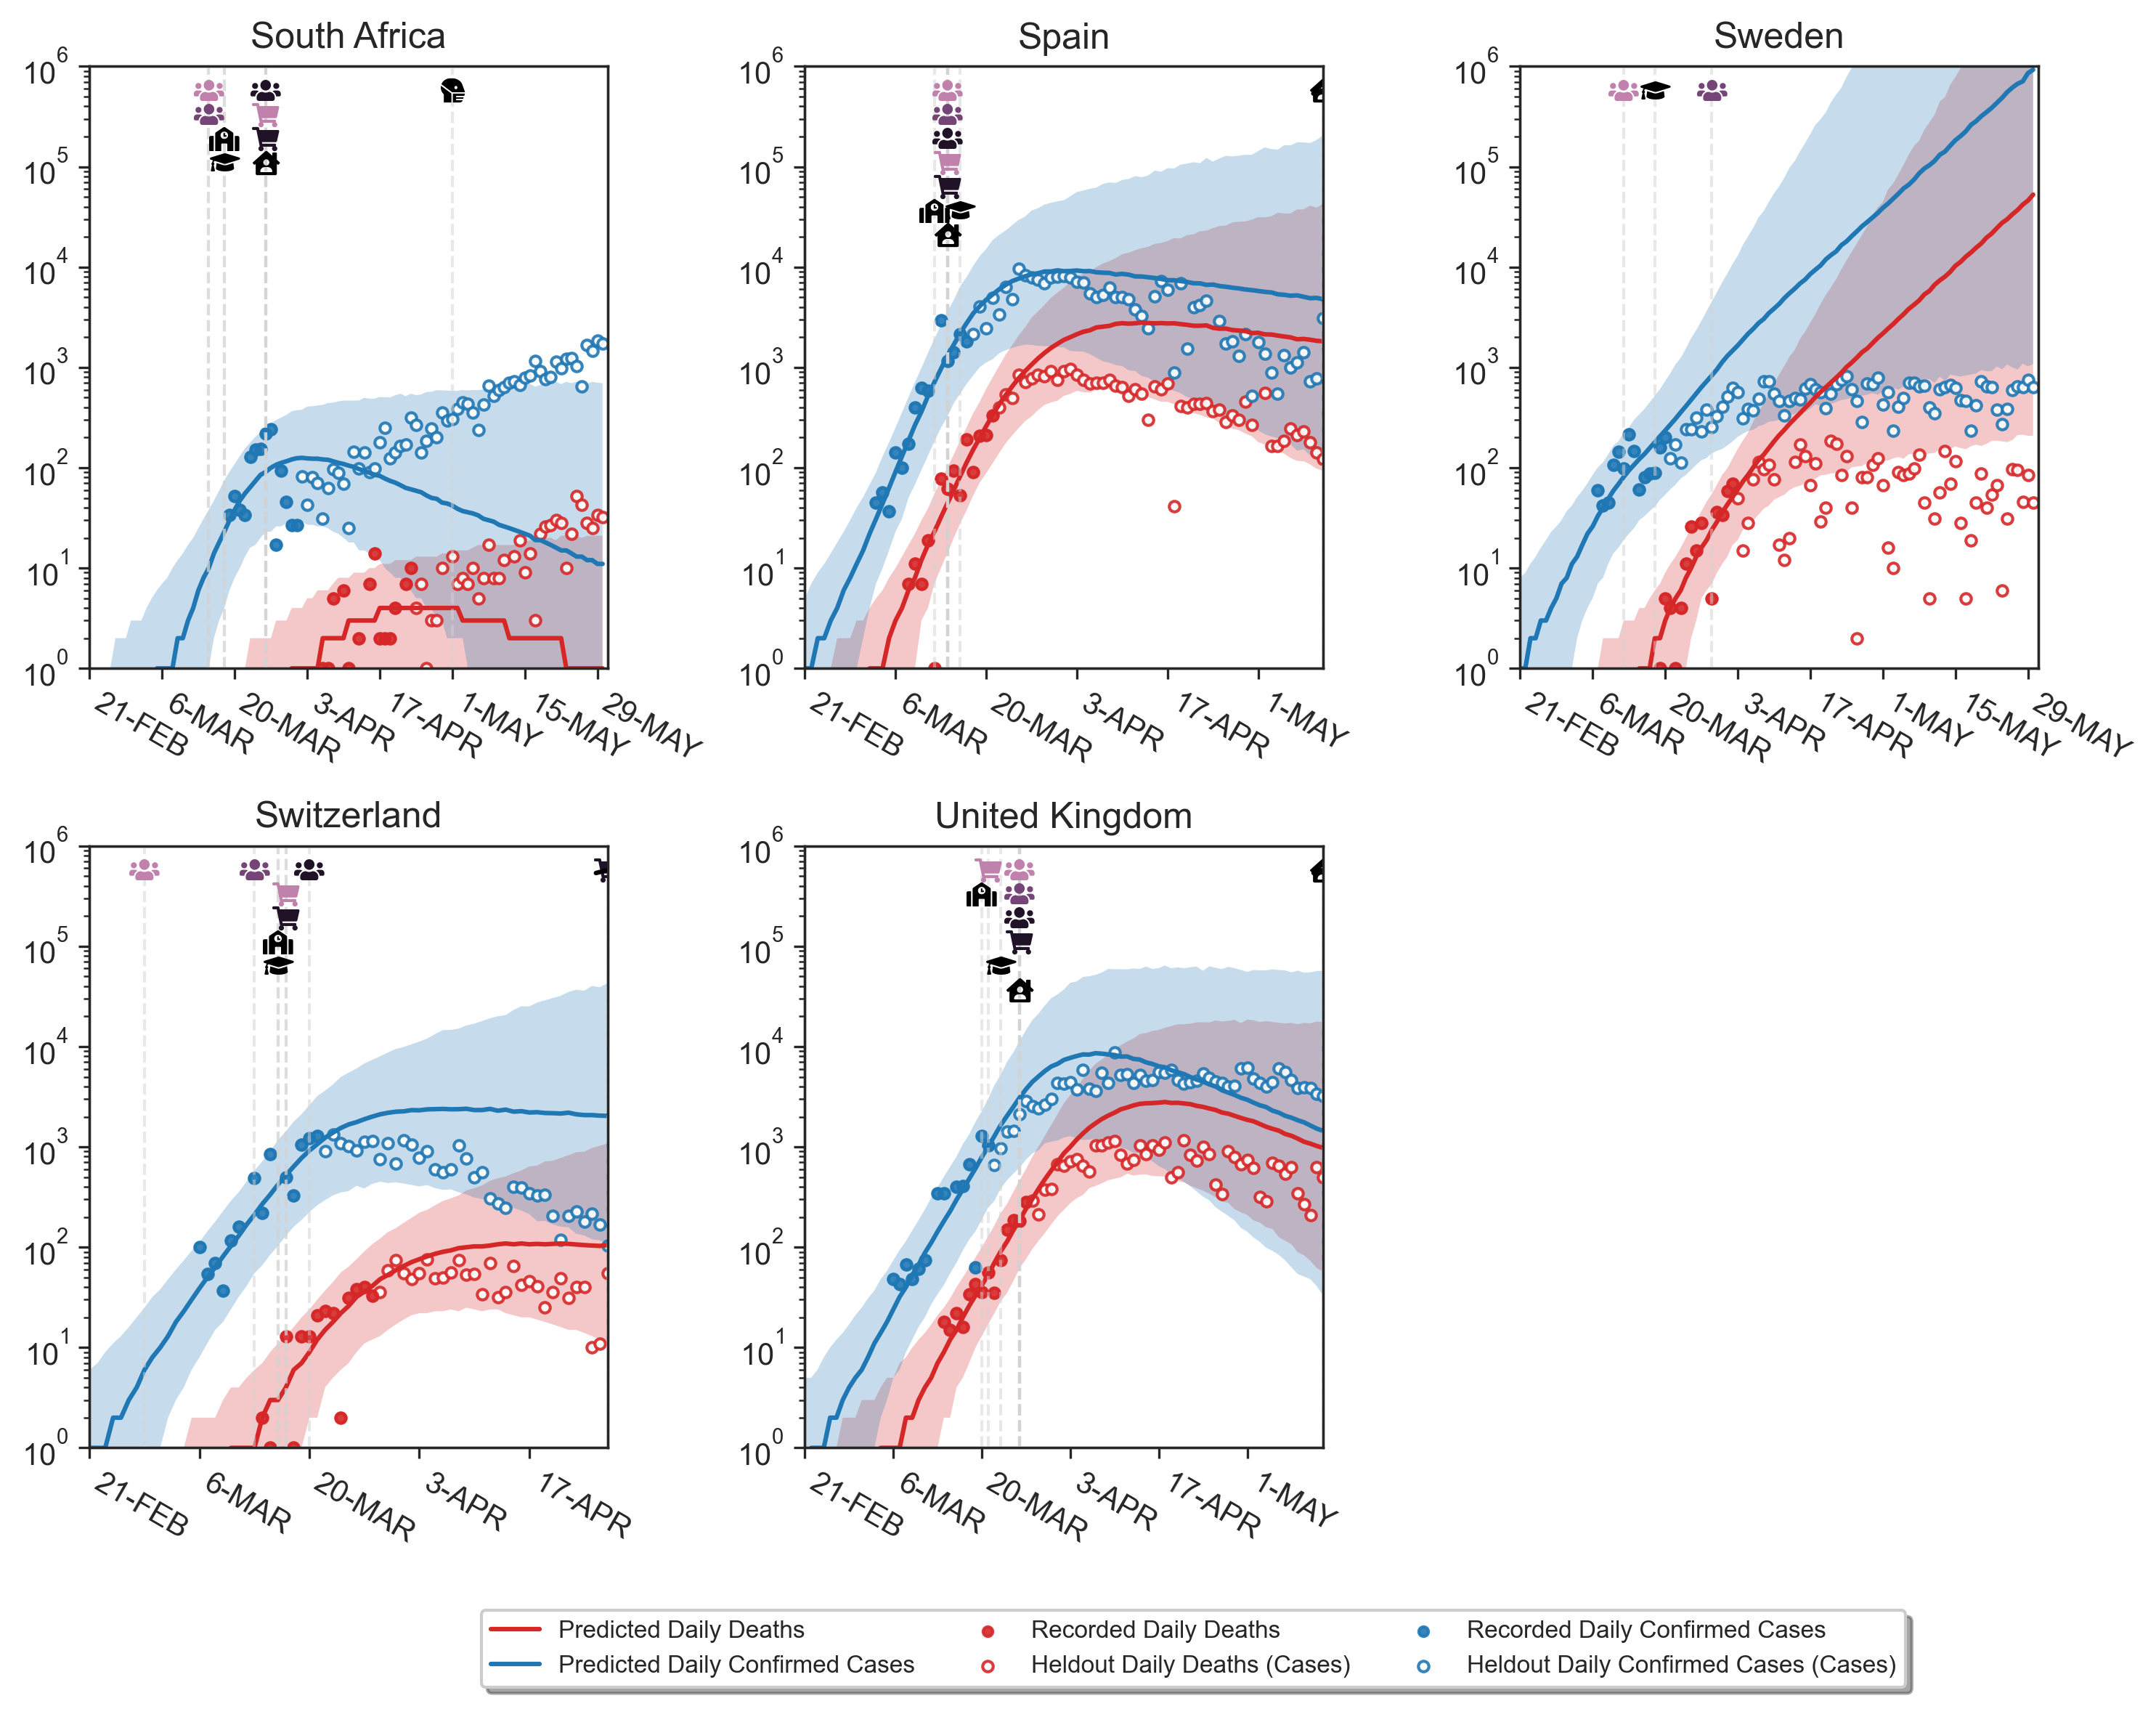

In [65]:
f;

# Calibration

In [66]:
from scipy.stats import nbinom

In [67]:
cdf_vals_cases = np.array([])
cdf_vals_deaths = np.array([])

data.unmask_all()
data.mask_reopenings(print_out=False)
# for r_i, r in enumerate(data.Rs):
for rg in data.Rs:
    r_i = data.Rs.index(f'{rg}')
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]+3
    else:
        end_d_i = len(data.Ds)
        
    end_d_i = len(data.Ds) if end_d_i > len(data.Ds) else end_d_i
    
    cases_start, deaths_start = data.mask_region(rg)
    
    try:   
        res = pickle.load(open(f"../../server/sensitivity_default/region_holdout/{rg}.pkl", "rb"))
    except:
        print(f'Could not load ../../server/sensitivity_default/region_holdout/{rg}.pkl')
        continue
    
    ed = res.ExpectedDeaths[:, deaths_start:end_d_i]
    nS, nDs_d = ed.shape
    
    ec = res.ExpectedCases[:, cases_start:end_d_i]
    nS, nDs_c = ec.shape
    
    try:
        alpha = np.repeat(res.PsiDeaths.reshape(nS, 1), nDs_d, axis = -1)
        p = alpha / (alpha + ed)
        cdf = nbinom.cdf(data.NewDeaths.data[r_i, deaths_start:(end_d_i)], alpha, p)
        cdf_vals_deaths = np.append(cdf_vals_deaths, np.mean(cdf, axis=0))
    except Exception as e:
        print(e)
        
    try:
        alpha = np.repeat(res.PsiCases.reshape(nS, 1), nDs_c, axis = -1)     
        p = alpha / (alpha + ec)
        cdf = nbinom.cdf(data.NewCases.data[r_i, cases_start:(end_d_i)], alpha, p)
        cdf_vals_cases = np.append(cdf_vals_cases, np.mean(cdf, axis=0))
    except Exception as e:
        print(e) 

In [68]:
agg_holdout_res = pickle.load(open(f"../../server/sensitivity_default/agg_holdout/results.pkl", "rb"))

In [69]:
cdf_vals_cases_agg = np.array([])
cdf_vals_deaths_agg = np.array([])

data.unmask_all()
data.mask_reopenings(n_extra=20, print_out=False)
# for r_i, r in enumerate(data.Rs):
for rg in data.Rs:
    r_i = data.Rs.index(f'{rg}')
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        start_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]
    else:
        start_d_i = len(data.Ds)
        
    end_d_i = start_d_i + 19
    end_d_i = len(data.Ds) if end_d_i > len(data.Ds) else end_d_i
        
    ed = agg_holdout_res.ExpectedDeaths[:, r_i, start_d_i:end_d_i]
    nS, nDs_d = ed.shape
    
    ec = agg_holdout_res.ExpectedCases[:, r_i, start_d_i:end_d_i]
    nS, nDs_c = ec.shape
    
    try:
        alpha = np.repeat(res.PsiDeaths.reshape(nS, 1), nDs_d, axis = -1)
        p = alpha / (alpha + ed)
        cdf = nbinom.cdf(data.NewDeaths.data[r_i, start_d_i:(end_d_i)], alpha, p)
        cdf_vals_deaths_agg = np.append(cdf_vals_deaths_agg, np.mean(cdf, axis=0))
    except Exception as e:
        print(e)
        
    try:
        alpha = np.repeat(res.PsiCases.reshape(nS, 1), nDs_c, axis = -1)     
        p = alpha / (alpha + ec)
        cdf = nbinom.cdf(data.NewCases.data[r_i, start_d_i:(end_d_i)], alpha, p)
        cdf_vals_cases_agg = np.append(cdf_vals_cases_agg, np.mean(cdf, axis=0))
    except Exception as e:
        print(e) 

In [80]:
plt.figure(figsize=(3.5, 3), dpi=300)
# plt.subplot(121)
all_cdf_vals = np.array(cdf_vals_cases)
all_cdf_vals = np.append(all_cdf_vals, cdf_vals_deaths)
all_cdf_vals_trans = 2*np.abs(all_cdf_vals - 0.5)

x_vals = np.linspace(0, 1, 100)
counts = [np.mean(all_cdf_vals_trans < x) for x in x_vals]
plt.plot(x_vals, counts, color=cols[0], linewidth=1.5)
plt.title('Calibration: Country Holdouts', fontsize=10)
plt.xlabel('Credible Interval', fontsize=9)
plt.ylabel('Empirical Cumulative Frequency', fontsize=9)
plt.plot([0, 1], [0, 1], 'k--', linewidth=0.5)

plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=8)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=8)
plt.xlim([0, 1])
plt.ylim([0, 1])

# plt.subplot(122)
# all_cdf_vals_agg = np.array(cdf_vals_cases_agg)
# all_cdf_vals_agg = np.append(all_cdf_vals_agg, cdf_vals_deaths_agg)
# all_cdf_vals_agg_trans = 2*np.abs(all_cdf_vals_agg - 0.5)
# x_vals = np.linspace(0, 1, 100)
# counts = [np.mean(all_cdf_vals_agg_trans < x) for x in x_vals]

# plt.plot(x_vals, counts, color=cols[1], linewidth=1.5)
# plt.title('Calibration: Aggregate Holdout', fontsize=10)
# plt.xlabel('Credible Interval', fontsize=9)
# plt.ylabel('Empirical Cumulative Frequency', fontsize=9)
# plt.xlim(plt.xlim())
# plt.plot([0, 1], [0, 1], 'k--', linewidth=0.5)
# plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=8)
# plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=8)
# plt.xlim([0, 1])
# plt.ylim([0, 1])

plt.tight_layout()
plt.savefig('figs/holdouts/FigureCal.pdf', bbox_inches='tight')

NameError: name 'f' is not defined

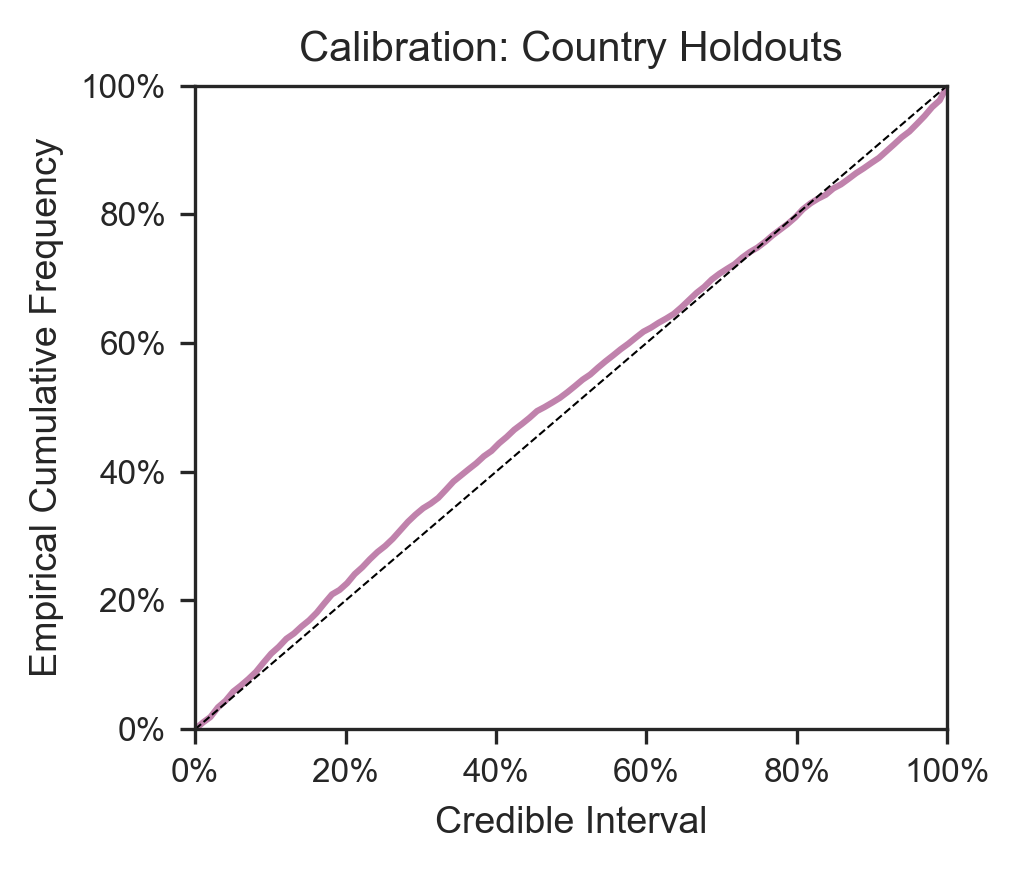

In [81]:
f;